In [1]:
import os
import re
import csv

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import numpy as np
import math


In [2]:
directory = "20230803"
p = re.compile(r"\d_\d\d\d")
instance_size_regex = re.compile(r"\d\d\d\d")

In [3]:
density_structure = {}
type_structure = {}

GROUNDING_TIME = "grounding_time"
GROUNDING_SIZE = "grounding_size"
TOTAL_TIME = "total_time"

GRINGO = "gringo"
IDLV = "idlv"
NEWGROUND_GRINGO = "newground-gringo"
NEWGROUND_IDLV = "newground-idlv"

grounder_types = [GRINGO, IDLV, NEWGROUND_GRINGO, NEWGROUND_IDLV]


file_types = [GROUNDING_TIME, GROUNDING_SIZE, TOTAL_TIME]

STAR_4 = "star_4"
STAR_6 = "star_6"
STAR_8 = "star_8"

stars = [STAR_4, STAR_6, STAR_8]

In [4]:
label_converter = {}
label_converter[GRINGO] = GRINGO
label_converter[IDLV] = IDLV
label_converter[NEWGROUND_GRINGO] = "NaGG-Gringo"
label_converter[NEWGROUND_IDLV] = "NaGG-IDLV"

In [5]:
for star in stars:
    type_structure[star] = {}
    density_structure[star] = {}

    for grounder_type in grounder_types:
        type_structure[star][grounder_type] = {}
        for file_type in file_types:
            type_structure[star][grounder_type][file_type] = {}


In [6]:
def generate_density_structure(file, density, file_type):
    
    dens_structure = {}

    dens_structure["filename"] = file
    dens_structure["density"] = density
    dens_structure["type"] = file_type
    file_data = pd.read_csv(os.path.join(directory, file), delimiter=',')    
    dens_structure["csv"] = file_data
    
    return (dens_structure)

In [7]:
def fill_type_structure(file_data, star, type_structure):

    for column_name in list(file_data.columns):
        for grounder_type in grounder_types:
            if column_name.startswith(grounder_type) and "timeout-occurred" not in column_name and "timeout-occured" not in column_name:
                if "instance_size" not in type_structure[star][grounder_type][file_type]:
                    type_structure[star][grounder_type][file_type]["instance_size"] = []
                if "instance_density" not in type_structure[star][grounder_type][file_type]:
                    type_structure[star][grounder_type][file_type]["instance_density"] = []
                if column_name not in type_structure[star][grounder_type][file_type]:
                    type_structure[star][grounder_type][file_type][column_name] = []


                list_instances = list(file_data["instance"])

                density_list = [int(density)] * len(list_instances)

                instance_size_list = [int((instance_size_regex.search(instance)).group(0)) for instance in list_instances]


                type_structure[star][grounder_type][file_type]["instance_size"] += instance_size_list
                type_structure[star][grounder_type][file_type]["instance_density"] += density_list

                raw_column_data = list(file_data[column_name])
                if "duration" in column_name:
                    parsed_column_data = [time if float(time) < 1800 else -1 for time in raw_column_data]
                elif "size" in column_name:
                    parsed_column_data = [float(size)/1024 if float(size) <= 32*(math.pow(10,6)) else -1 for size in raw_column_data]
                else:
                    print("THIS SHOULD NEVER HAPPEN!")

                type_structure[star][grounder_type][file_type][column_name] += parsed_column_data
                



In [8]:
# Parse all files into density_structure and type_structure
for root, dirs, files in os.walk(directory):
    for file in files:
            
        result = p.search(file)
        
        if result is not None:
            star_density = result.group(0)
            
            star = None
            
            if star_density.startswith("4"):
                star = STAR_4
            elif star_density.startswith("6"):
                star = STAR_6
            elif star_density.startswith("8"):
                star = STAR_8
            else:
                print("ERROR!!! star not found!!!")
                
            density = star_density[2:]
           
            if density not in density_structure[star]:
                density_structure[star][density] = {}

            for file_type in file_types:
                if file_type in file:
                    local_density_structure = generate_density_structure(file, density, file_type)
                    density_structure[star][density][file_type] = local_density_structure
                    
                    fill_type_structure(local_density_structure["csv"], star, type_structure)
                    
                   

In [9]:
for star in stars:
    for grounder_type in grounder_types:
        for file_type in file_types:        
            instance_size = type_structure[star][grounder_type][file_type]["instance_size"]
            instance_density = type_structure[star][grounder_type][file_type]["instance_density"]

            special_name = None
            for key in type_structure[star][grounder_type][file_type].keys():
                if "instance" not in key and "data_frame" not in key:
                    special_name = key

            special = type_structure[star][grounder_type][file_type][special_name]

            data_dict = {
                "instance_size":instance_size,
                "instance_density":instance_density,
                special_name: special
            }


            data_frame = pd.DataFrame(data_dict)
            type_structure[star][grounder_type][file_type]["data_frame"] = data_frame

            cpy_df = data_frame.copy()
            cpy_df = cpy_df.drop(cpy_df[cpy_df[special_name] < 0].index)
            type_structure[star][grounder_type][file_type]["parsed_df"] = cpy_df        

In [10]:
combinations = []
for star in stars:
    
    if star == STAR_4:
        star_name = "4"
    elif star == STAR_6:
        star_name = "6"
    elif star == STAR_8:
        star_name = "8"
    
    combinations += [((star,GRINGO,GROUNDING_SIZE),(star,GRINGO,GROUNDING_TIME), "grounding time [s] (left half)", f"{star_name} GRINGO"),
               ((star,IDLV,GROUNDING_SIZE),(star,IDLV,GROUNDING_TIME), "grounding time [s] (left half)", f"{star_name} IDLV"),
               ((star,NEWGROUND_GRINGO,GROUNDING_SIZE),(star,NEWGROUND_GRINGO,GROUNDING_TIME), "grounding time [s] (left half)", f"{star_name} NEWGROUND-GRINGO"),
               ((star,NEWGROUND_IDLV,GROUNDING_SIZE),(star,NEWGROUND_IDLV,GROUNDING_TIME), "grounding time [s] (left half)", f"{star_name} NEWGROUND-IDLV"),
               ((star,GRINGO,GROUNDING_SIZE),(star,GRINGO,TOTAL_TIME), "total solving time [s] (left half)", f"{star_name} GRINGO"),
               ((star,IDLV,GROUNDING_SIZE),(star,IDLV,TOTAL_TIME), "total solving time [s] (left half)", f"{star_name} IDLV"),
               ((star,NEWGROUND_GRINGO,GROUNDING_SIZE),(star,NEWGROUND_GRINGO,TOTAL_TIME), "total solving time [s] (left half)", f"{star_name} NEWGROUND-GRINGO"),
                ((star,NEWGROUND_IDLV,GROUNDING_SIZE),(star,NEWGROUND_IDLV,TOTAL_TIME), "total solving time [s] (left half)", f"{star_name} NEWGROUND-IDLV")]


In [11]:
combinations = []
for star in stars:
    
    if star == STAR_4:
        star_name = "4"
    elif star == STAR_6:
        star_name = "6"
    elif star == STAR_8:
        star_name = "8"
    
    y_label_grounding_time = "Grounding Time [s] (left half)"
    y_label_total_time = "Combined Time [s] (left half)"
    
    combinations += [((star,GRINGO,GROUNDING_SIZE),(star,GRINGO,GROUNDING_TIME), y_label_grounding_time , f"{star_name} GRINGO"),
               ((star,IDLV,GROUNDING_SIZE),(star,IDLV,GROUNDING_TIME), y_label_grounding_time, f"{star_name} IDLV"),
               ((star,NEWGROUND_GRINGO,GROUNDING_SIZE),(star,NEWGROUND_GRINGO,GROUNDING_TIME), y_label_grounding_time, f"{star_name} NEWGROUND-GRINGO"),
               ((star,NEWGROUND_IDLV,GROUNDING_SIZE),(star,NEWGROUND_IDLV,GROUNDING_TIME), y_label_grounding_time, f"{star_name} NEWGROUND-IDLV"),
               ((star,GRINGO,GROUNDING_SIZE),(star,GRINGO,TOTAL_TIME),y_label_total_time , f"{star_name} GRINGO"),
               ((star,IDLV,GROUNDING_SIZE),(star,IDLV,TOTAL_TIME), y_label_total_time, f"{star_name} IDLV"),
               ((star,NEWGROUND_GRINGO,GROUNDING_SIZE),(star,NEWGROUND_GRINGO,TOTAL_TIME), y_label_total_time, f"{star_name} NEWGROUND-GRINGO"),
                ((star,NEWGROUND_IDLV,GROUNDING_SIZE),(star,NEWGROUND_IDLV,TOTAL_TIME), y_label_total_time, f"{star_name} NEWGROUND-IDLV")]


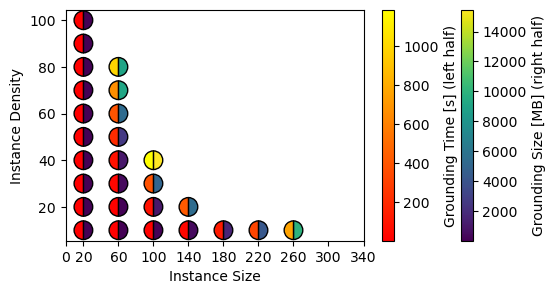

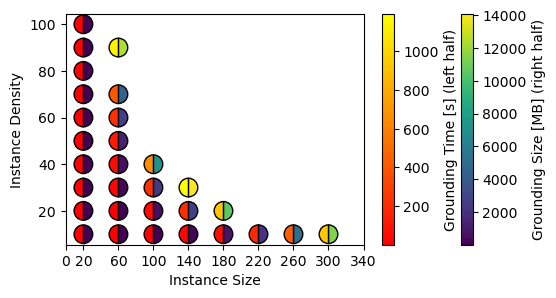

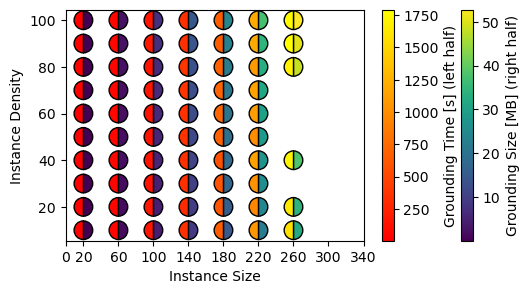

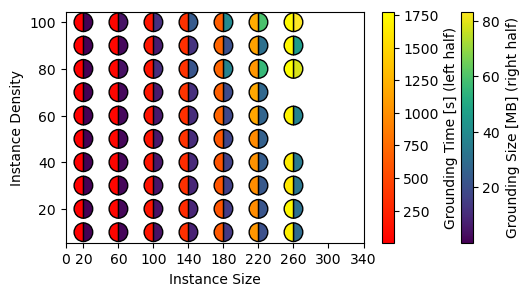

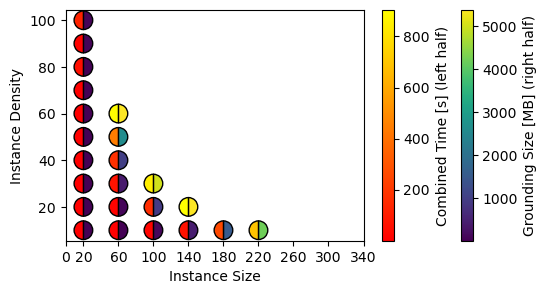

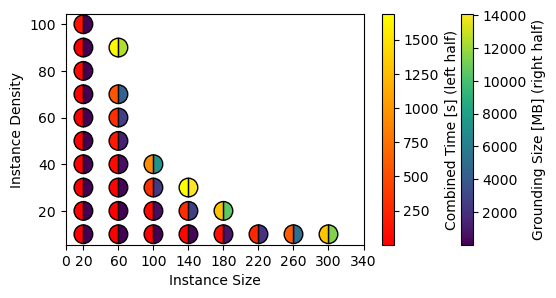

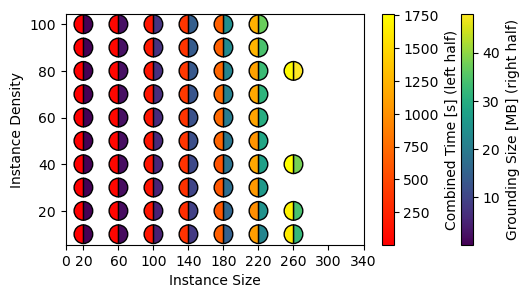

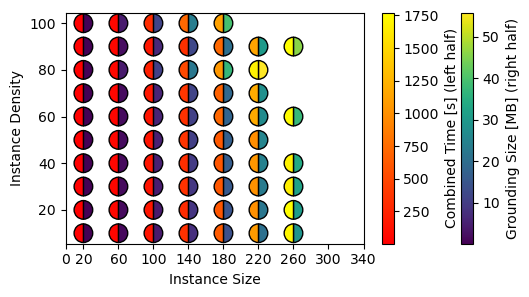

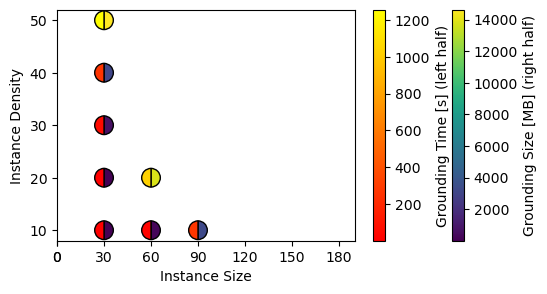

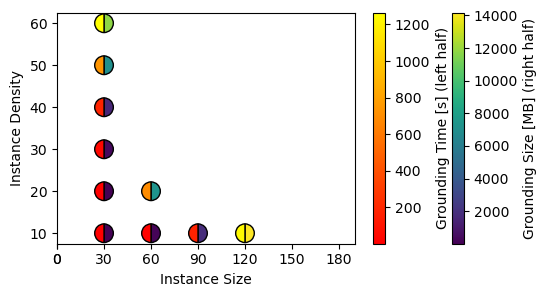

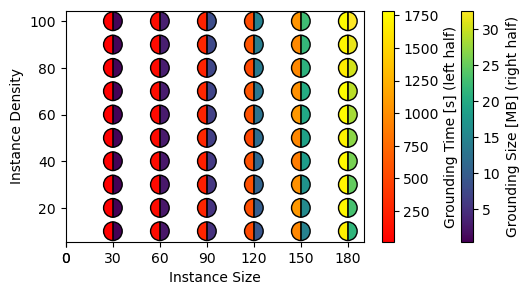

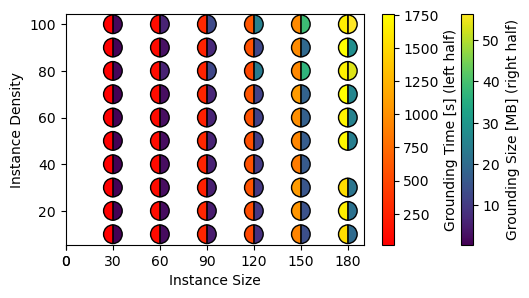

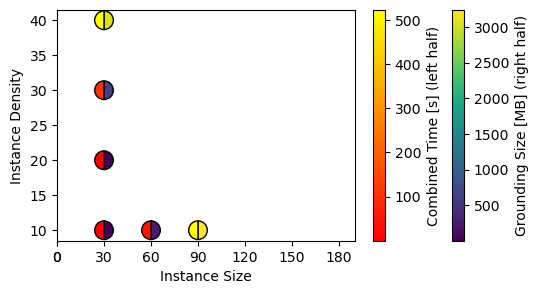

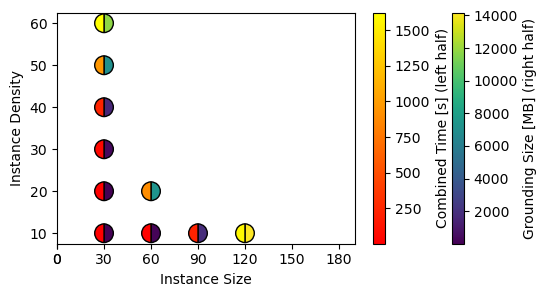

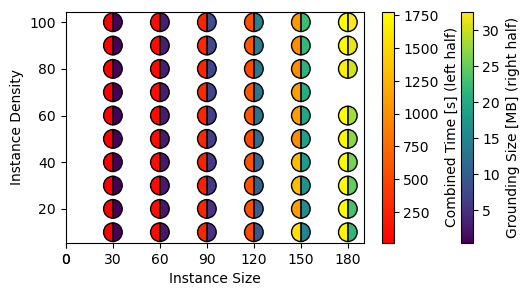

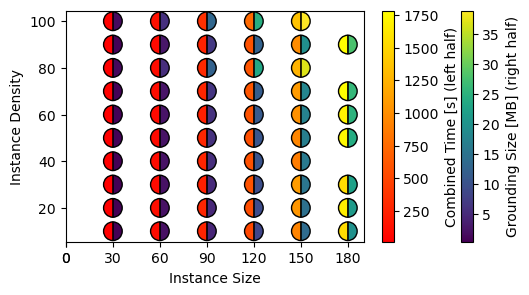

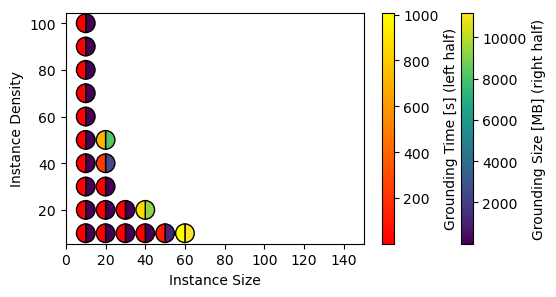

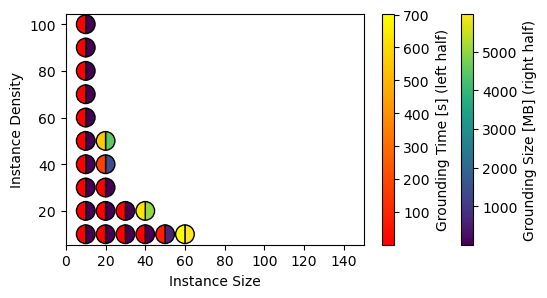

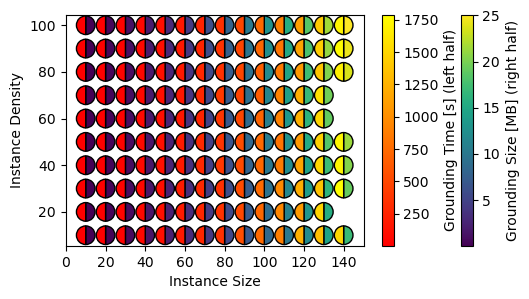

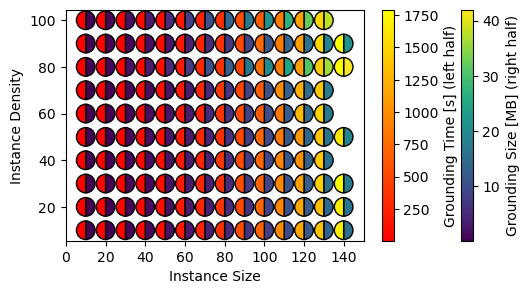

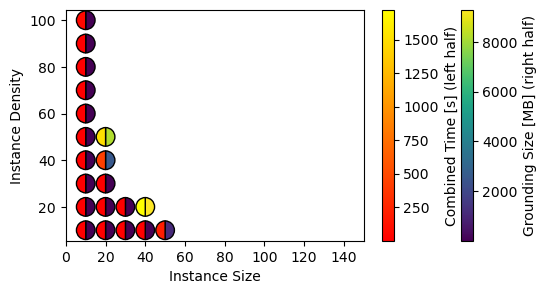

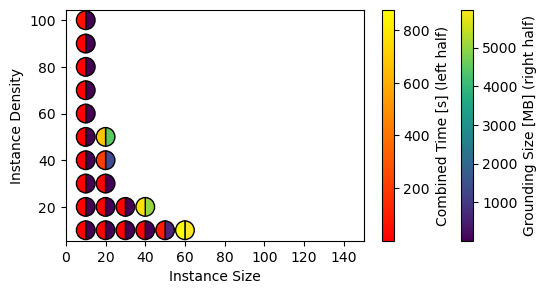

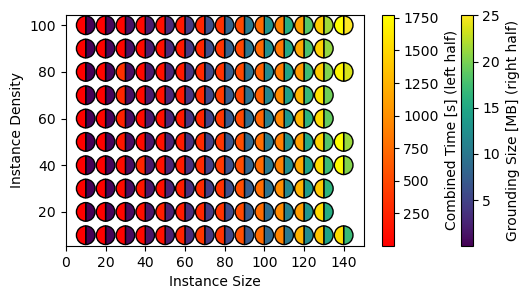

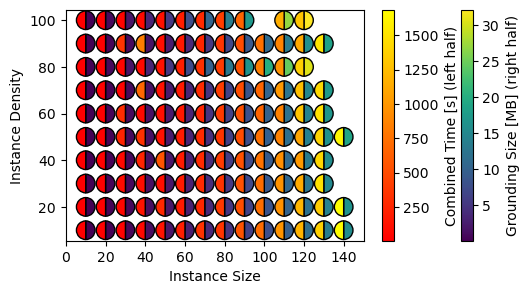

In [12]:
fix_color_bar = False

for combination in combinations:
    label = f"Relaxed Traffic {combination[3]}"
    plot_file_name = f"S3_T{combination[0][0]}_{label_converter[combination[0][1]]}_{combination[0][2]}_{combination[1][2]}.svg"
    
    data_frame = (type_structure[combination[0][0]][combination[0][1]][combination[0][2]]["parsed_df"]).copy()
    time_frame = (type_structure[combination[1][0]][combination[1][1]][combination[1][2]]["parsed_df"]).copy()
    
    
    data_frame_size_density = []
    for index, row in data_frame.iterrows():
        data_frame_size_density.append((row["instance_size"], row["instance_density"]))
        
    time_frame_size_density = []
    for index, row in time_frame.iterrows():
        time_frame_size_density.append((row["instance_size"], row["instance_density"]))
        
    intersected_instances = list(set(data_frame_size_density).intersection(set(time_frame_size_density)))   
    
    
    marked_deletion_data = []
    for index, row in data_frame.iterrows():
        if ((row["instance_size"], row["instance_density"])) not in intersected_instances:
            marked_deletion_data.append(index)
        
    marked_deletion_time = []
    for index, row in time_frame.iterrows():
        if ((row["instance_size"], row["instance_density"])) not in intersected_instances:
            marked_deletion_time.append(index)
            
    data_frame = data_frame.drop(marked_deletion_data)
    time_frame = time_frame.drop(marked_deletion_time)    
    
    if combination[0][0] == STAR_4:   
        #not_shown_list = [10,12,14,16,18,20,40,50,70,80,100,110,130,140, 300, 310]
        not_shown_list = [10,12,14,16,18,30,40,50,70,80,90,110,120,130,150, 310, 320]
    elif combination[0][0] == STAR_6:
        not_shown_list = [10,12,14,16,18,20,40,50,70,80,100,110,130,140]
        #not_shown_list = [12,14,16,18,20,40,60,80,100,120,140]
    elif combination[0][0] == STAR_8:
        not_shown_list = [12,14,16,18]

    data_frame = data_frame[~data_frame["instance_size"].isin(not_shown_list)]    
    time_frame = time_frame[~time_frame["instance_size"].isin(not_shown_list)]
    
    plotsize = (6, 3)
    
    plt.figure(figsize=plotsize)
    
    
    if fix_color_bar == False:
        data_X = list(data_frame["instance_size"])
        data_Y = list(data_frame["instance_density"])
        data_Z = list(data_frame.iloc[:,2])
    else:
        # The additional ''fake'' example (460, 90, 32000) is added to generate static color ranges
        data_X = list(data_frame["instance_size"])+[460]
        data_Y = list(data_frame["instance_density"])+[90]
        data_Z = list(data_frame.iloc[:,2])+[32000]
    
    plt.scatter(data_X, data_Y, linewidth=1,edgecolor="black",s=180,c=data_Z,marker=MarkerStyle("o", fillstyle="right"), cmap="viridis") #viridis") #,marker="*",color='blue')
    cbar=plt.colorbar()
    cbar.set_label("Grounding Size [MB] (right half)", rotation=90)

    if fix_color_bar == False:
        time_X = list(time_frame["instance_size"])
        time_Y = list(time_frame["instance_density"])
        time_Z = list(time_frame.iloc[:,2])
    else:
        # The additional ''fake'' example (460, 90, 1800) is added to generate static color ranges
        time_X = list(time_frame["instance_size"])+[460]
        time_Y = list(time_frame["instance_density"])+[90]
        time_Z = list(time_frame.iloc[:,2])+[1800]
    
    plt.scatter(time_X, time_Y, linewidth=1,edgecolor="black",s=180,c=time_Z,marker=MarkerStyle("o", fillstyle="left"), cmap="autumn") #plasma") #autumn") #viridis") #,marker="*",color='blue')
    cbar=plt.colorbar()
    cbar.set_label(combination[2], rotation=90)
    
    #plt.title(label)

    plt.xlabel("Instance Size") #tmeasures[a])
    plt.ylabel("Instance Density") #tmeasures[b])
    
        
    if combination[0][0] == STAR_4:    
        plt.xlim([0, 340])
        arr = np.arange(20, 350, 40)
        arr = np.insert(arr, 0, 0, axis=0)
        plt.xticks(arr)
    elif combination[0][0] == STAR_6:
        plt.xlim([0, 190])
        
        arr = np.arange(0, 195, 30)
        arr = np.insert(arr, 0, 0, axis=0)
        plt.xticks(arr)
    elif combination[0][0] == STAR_8:
        plt.xlim([0, 150])
        
        arr = np.arange(20, 150, 20)
        arr = np.insert(arr, 0, 0, axis=0)
        plt.xticks(arr)

    plt.show()
    #plt.savefig(plot_file_name, bbox_inches='tight', transparent=True)
    plt.close('all')

In [25]:
arr = np.arange(20, 330, 40)

array([  0,  20,  60, 100, 140, 180, 220, 260, 300])